A simple implementation of the copy-gadget outlined in this paper: Quantum Optimization with Arbitrary Connectivity Using Rydberg Atom Arrays

In [279]:
from dataclasses import replace
from matplotlib import pyplot as plt
from pulser.devices import Chadoq2
from pulser.register import Register
from pulser.register.register_layout import RegisterLayout
from pulser.register.mappable_reg import MappableRegister
from pulser.register.weight_maps import DetuningMap
from pulser_simulation import QutipEmulator
from pulser.waveforms import InterpolatedWaveform
from pulser.sampler import sampler
from pulser.sequence import Sequence
from pulser.pulse import Pulse
from pulser.waveforms import ConstantWaveform, RampWaveform
import numpy as np

First we define our qubit coordinates and define a "register".

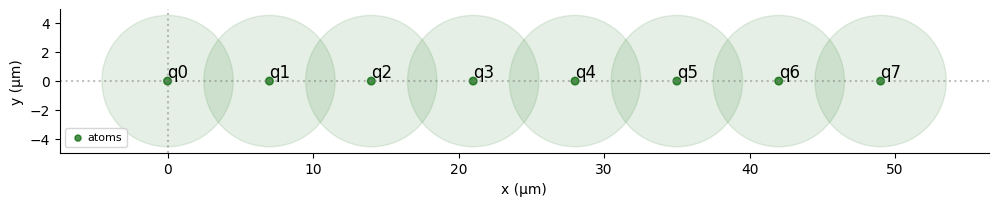

In [280]:
N = 8
L = 7.0
omgega_max = 10

trap_coordinates = [(i*L,0.0) for i in range(N)]
weights = np.ones((N))

register = Register.from_coordinates(trap_coordinates, center=False, prefix="q")
register.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(10),
    draw_graph=False,
    draw_half_radius=True,
)

We need to define a "sequence" object. A "sequence" object is basically the sequence of operations occurring in the analogue simulation.

In this simple experiment all the traps experience a global rydberg beam. To define this for the sequence we "declare a channel" named "rydberg_global" with the alias "ch0" which we chose. Note that "rydberg_global" is a special pulsar flag, it is not an arbitrarily name we've chosen.

In [281]:
seq = Sequence(register, Chadoq2)
print("list of possible channels:" + str(list(seq.available_channels.keys())))
seq.declare_channel("ch0", "rydberg_global")
print(seq.declared_channels)

list of possible channels:['rydberg_global', 'rydberg_local', 'raman_local', 'dmm_0']
{'ch0': Rydberg.Global(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 15.707963267948966 rad/µs, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'ground-rydberg')}


In our sequence, we need to sweep the detuning from a negative value to a positive value, while the Rabii frequency (Electric field) goes up and down in an adiabatic fashion.

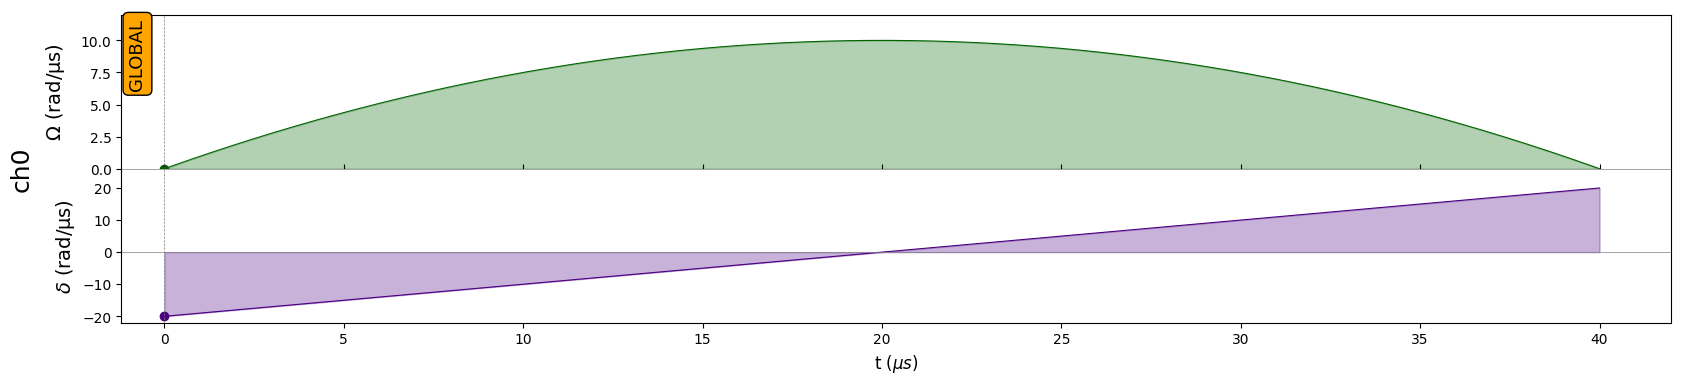

In [282]:
delta_abs = 20
T = 40000 # in ns, time of the signal

adiabatic_pulse = Pulse(
    amplitude = InterpolatedWaveform(T, [1e-9, omega_max, 1e-9]), # By default, interpolate just connects the dots with cubic functions
    detuning = InterpolatedWaveform(T, [-delta_abs, delta_abs]),
    phase = 0
)
seq.add(adiabatic_pulse, "ch0")
seq.draw()

Now we just run the simulation

In [283]:
simul = QutipEmulator.from_sequence(seq)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()

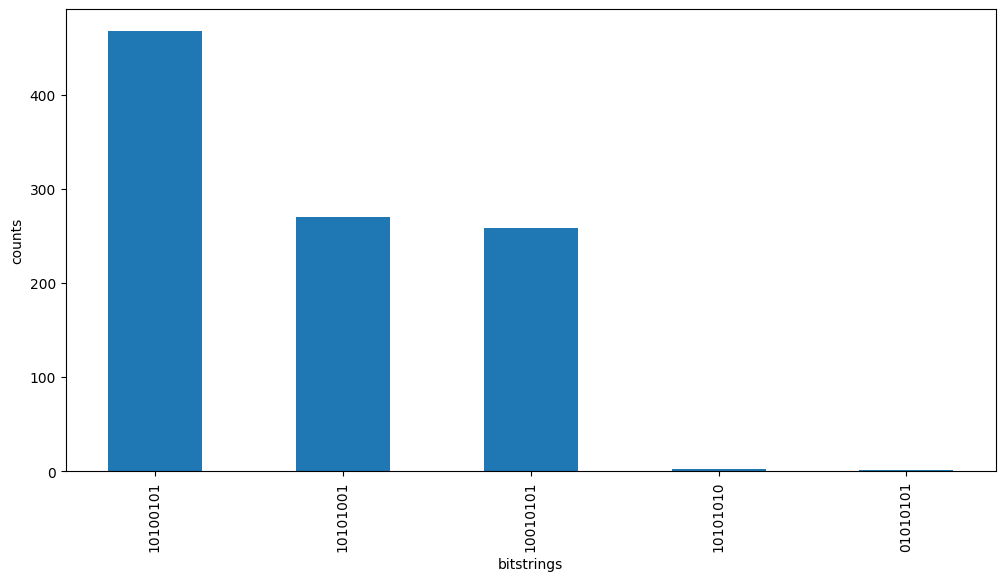

In [284]:
count_dict = dict(sorted(count_dict.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(12, 6))
plt.xlabel("bitstrings")
plt.ylabel("counts")
plt.bar(count_dict.keys(), count_dict.values(), width=0.5)
plt.xticks(rotation="vertical")
plt.show()

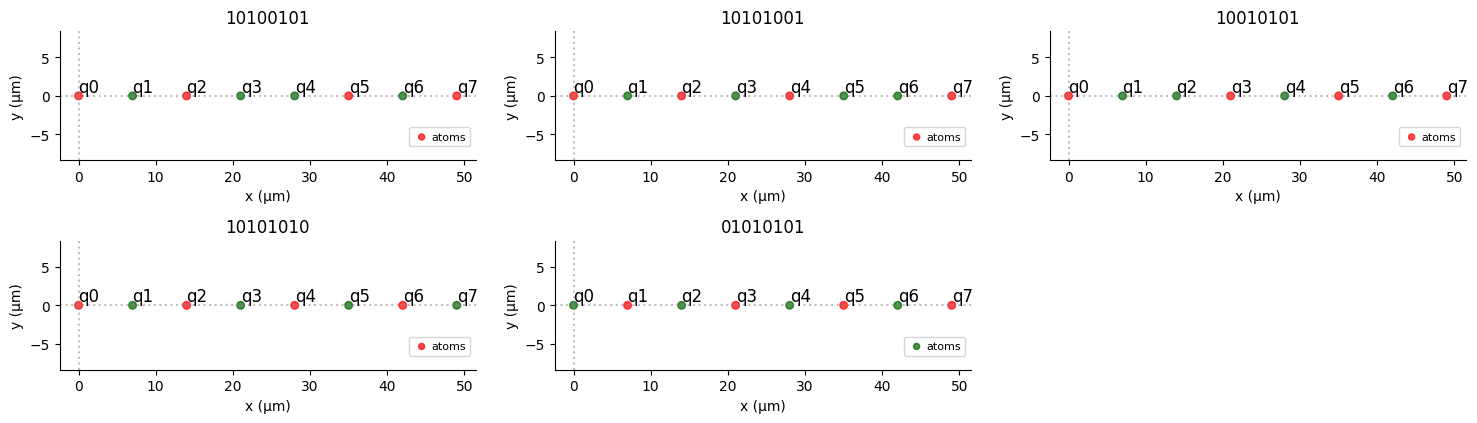

In [285]:
fig, ax = plt.subplots(3, 3, figsize=(15, 6))
ax = ax.ravel()

for i in range(min(len(ax), len(count_dict))):
    m = list(count_dict.keys())[i]
    register.draw(
        qubit_colors={f"q{k}": "red" for k in range(len(m)) if m[k] == '1'},
        show = False,
        custom_ax=ax[i]
    )
    ax[i].set_title(m)
for i in range(len(count_dict), len(ax)):
    ax[i].set_visible(False)

plt.tight_layout()
plt.show()